In [1]:
import argparse
import os
import time
import torch
import numpy as np
from tqdm import tqdm
from scipy.signal import butter, filtfilt

from BioMime.utils.basics import update_config, load_generator
from BioMime.utils.plot_functions import plot_muaps
from BioMime.utils.params import num_mus, steps, tgt_params
from BioMime.models.generator import Generator

from models import ConditionBiomime
from muap_to_emg import *


In [2]:
# load and create the muap generator
cfg = update_config('./config/config.yaml')

generator = Generator(cfg.Model.Generator)
generator = load_generator('ckp/model_linear.pth', generator, 'cuda:0')


In [3]:

zi = torch.randn(1, cfg.Model.Generator.Latent).repeat([1, 1])
biomime_cond = ConditionBiomime(generator, zi, device='cpu')

In [70]:
n_mus_base = 5  
base_cond = torch.rand(n_mus_base, 6,)
muaps = biomime_cond.cpu()(base_cond).reshape(n_mus_base, 96, 320).permute(0, 2, 1).detach().numpy()

In [71]:

spts, dts  = generate_spike_trains(n_mus_base, 20, 1000, )
emg = generate_emg(spts, muaps[:n_mus_base])

100%|██████████| 5/5 [00:00<00:00,  5.94it/s]


In [72]:
muaps = torch.tensor(muaps)
R = 10

In [73]:
import scipy
import matplotlib.pyplot as plt
# prepare
R = 10
extended_emg = np.zeros((emg.shape[0]*R, emg.shape[1] + R - 1)) # create extended EMG template

extended_emg = extend_emg(extended_emg, emg, R)
whitened_emg, whitening_mat, dewhitening_mat = whiten_emg(extended_emg)

100%|██████████| 10/10 [00:00<00:00, 74.80it/s]


FINISHED GETTING COVARIANCE MATRIX...
FINISHED GETTING EIGENDECOMPOSITION...
FINISHED INVERTING DIAGONAL MATRIX...


In [74]:
training_data = torch.tensor(whitened_emg, dtype=torch.float32)
training_data.shape

filters = torch.tensor(get_separation_vectors(muaps[:N_mus], R=R))

whitening_tensor = torch.tensor(whitening_mat, dtype=torch.float32)

/tmp/ipykernel_209017/2835151102.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  filters = torch.tensor(get_separation_vectors(muaps[:N_mus], R=R))


In [75]:
training_data.cuda()
filters.cuda()
filters = (whitening_tensor @ filters).T

In [76]:
extended_emg.shape

(3200, 20009)

In [77]:
from models import *

negen_loss = NegentropyLoss()

In [78]:
import torch
import torch.optim as optim

# -----------
# HYPOTHETICAL EXTERNALS 
# -----------
# biomime:         your pretrained BioMime model
# initial_input:   some initial (batch_size x n_features) Tensor, in [0,1]
# zi:              additional condition for biomime.sample
# R, whitening_tensor, n_mus, training_data: placeholder references to your data
# get_separation_vectors: you must ensure this function is PyTorch-friendly
# -----------
# Suppose we have:

device = 'cuda:0'
n_mus_search = 5  # number of motor units or waveforms to sample, for example
initial_cond = base_cond[0:5]#torch.rand(n_mus_search, 6)#torch.tensor([[0.2535, 0.6657, 0.3464, 0.9506, 0.8990, 0.0827]])

# Create ConditionOptimizer
model = ConditionOptimizer(
    biomime=generator,
    initial_input=initial_cond.clone().detach(),
    zi=zi,
    indices=[0, 1, 2, 3, 4, 5],  # e.g. just 2 learnable parameters
    device=device
).to(device)

# Create an optimizer on the model's parameters
optimizer = optim.Adam([model.opt_params], lr=1e-7)

# Transfer everything needed to device
whitening_tensor = whitening_tensor.to(device)
training_data = training_data.to(device)
whitening_tensor.to(device)

kurt_per_mu_last = torch.zeros(n_mus_search, device=device)

kurt_per_mu_all = []
# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    # 1) Zero out gradients
    optimizer.zero_grad()

    # 2) Forward pass through ConditionOptimizer => BioMime => MUAP waveforms
    muaps = model.forward(n_mus_search)   # shape e.g. [n_mus, ...whatever shape...]
    muaps = muaps.reshape(n_mus_search, 96, 320).permute(0, 2, 1)
    # Suppose shape is (n_mus, 96, 320), as in your example:
    # muaps = muaps.reshape(n_mus, 96, 320).permute(0, 2, 1)

    # 3) Construct filters in Torch
    # get_separation_vectors should be a PyTorch function 
    # returning a torch.Tensor that maintains gradient if needed
    filters = get_separation_vectors(muaps, R=R)
    
    #filters = filters / torch.norm(filters)

    # filters shape might be [n_mus, num_channels], etc.

    # 4) Multiply by whitening tensor
    # (whitening_tensor @ filters) => shape depends on your usage
    filters = whitening_tensor @ filters  
    # maybe you want filters transposed, depends on your dimension logic
    filters = filters.T

    # 5) Filter your training_data
    # E.g. pick the first filter for demonstration
    # shape for filters[[0], :] might be [1, channels] 
    # training_data might be [channels, time_points]
    # => result is [1, time_points]
    #mu1 = (filters[[0], :] @ training_data).squeeze(0)
    mu1 = filters @ training_data
    # mu1 is now [time_points]

    # 6) Compute kurtosis
    kurt_per_mu = -torch_kurtosis(mu1)
    kurt = kurt_per_mu.sum()  # This is a PyTorch Tensor


    # 7) Define loss
    # If you want to maximize kurtosis, you can do loss = -kurt
    loss = kurt
    # 8) Backprop

    loss.backward()


    # 9) Update
    #optimizer.step()
    kurt_per_mu_all.append(kurt_per_mu.detach().cpu().numpy())

    # if (epoch+1) % 20 == 0:
    #     with torch.no_grad():
    #         #mask = ((kurt_per_mu - kurt_per_mu_last)/kurt_per_mu_last < 3.0) & (kurt_per_mu < 10)
    #         mask = kurt_per_mu < 0
    #         indices = torch.where(mask)[0]
    #         print(len(indices))
    #         #print(indices)
    #         kurt_per_mu_last = kurt_per_mu
    #         for index in indices:
    #             model.opt_params[index] = torch.rand(6)
    #             kurt_per_mu[index] = 0.
             


    # 10) (Optional) Print or log stats
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {loss.item():.6f} - Kurt: {kurt.item():.6f}")
        print("Current conditions:", model.get_conditions()[0].data.cpu().numpy())


Epoch [10/200] - Loss: -50.261074 - Kurt: -50.261074
Current conditions: [0.9837107  0.9116226  0.38376033 0.55811936 0.30178428 0.13730133]
Epoch [20/200] - Loss: -50.261074 - Kurt: -50.261074
Current conditions: [0.9837107  0.9116226  0.38376033 0.55811936 0.30178428 0.13730133]
Epoch [30/200] - Loss: -50.261074 - Kurt: -50.261074
Current conditions: [0.9837107  0.9116226  0.38376033 0.55811936 0.30178428 0.13730133]
Epoch [40/200] - Loss: -50.261074 - Kurt: -50.261074
Current conditions: [0.9837107  0.9116226  0.38376033 0.55811936 0.30178428 0.13730133]
Epoch [50/200] - Loss: -50.261074 - Kurt: -50.261074
Current conditions: [0.9837107  0.9116226  0.38376033 0.55811936 0.30178428 0.13730133]
Epoch [60/200] - Loss: -50.261074 - Kurt: -50.261074
Current conditions: [0.9837107  0.9116226  0.38376033 0.55811936 0.30178428 0.13730133]
Epoch [70/200] - Loss: -50.261074 - Kurt: -50.261074
Current conditions: [0.9837107  0.9116226  0.38376033 0.55811936 0.30178428 0.13730133]


KeyboardInterrupt: 

In [84]:
mu1 = filters @ training_data


IndexError: index 5 is out of bounds for axis 0 with size 5

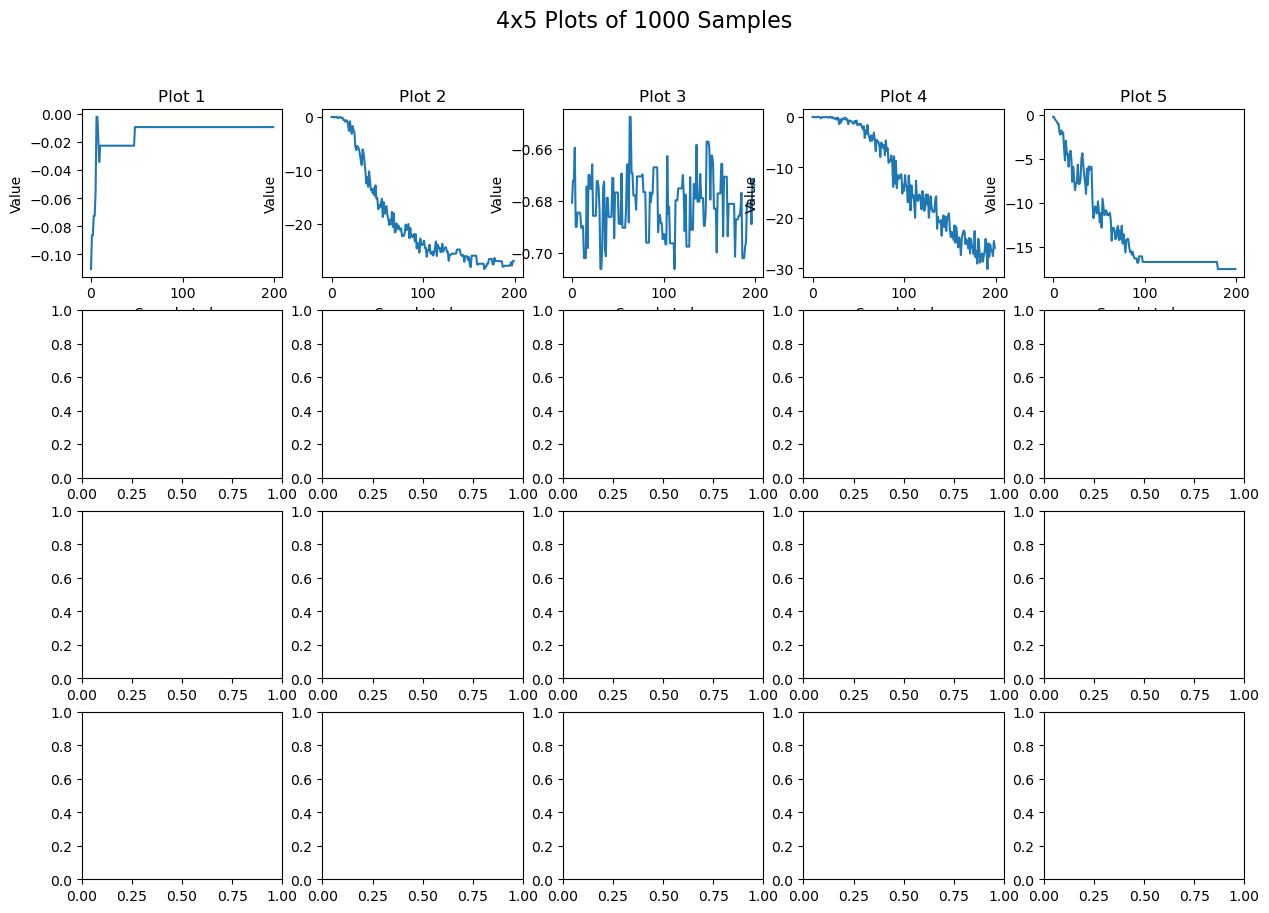

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a 20x1000 random NumPy matrix for demonstration
data = np.vstack(kurt_per_mu_all).T

# Create a 4x5 grid of subplots
fig, axes = plt.subplots(4, 5, figsize=(15, 10))
fig.suptitle("4x5 Plots of 1000 Samples", fontsize=16)

# Flatten axes for easier indexing
axes = axes.flatten()

# Plot each row of the matrix
for i in range(20):
    ax = axes[i]
    ax.plot(data[i])
    ax.set_title(f"Plot {i + 1}")
    ax.set_xlabel("Sample Index")
    ax.set_ylabel("Value")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle
plt.show()


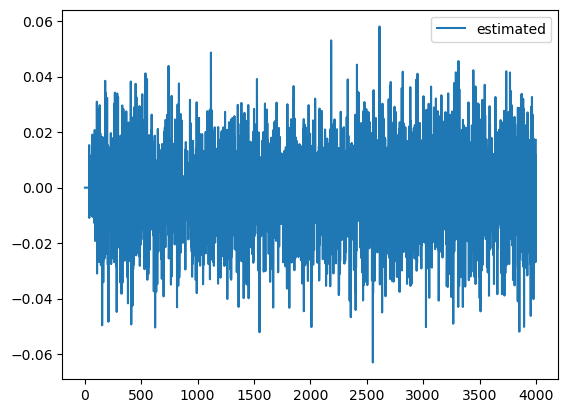

In [107]:
#mu1 = (B[[25], :] @  whitened_emg).ravel()
i = 1
plt.figure()
plt.plot((mu1[i][0:4000]/ mu1[i].max()).detach().cpu().numpy() )
#plt.plot(spts[27,:][0:4000]/spts.max())
plt.legend(['estimated', 'original'])
# plt.savefig('mu')
plt.show()

### Joao look here

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def calculate_kmeans_and_silhouette(points, n_clusters=2):
    """
    Perform k-means clustering and calculate the silhouette score.

    Parameters:
    points (numpy.ndarray): 1D array of points.
    n_clusters (int): Number of clusters for k-means. Default is 2.

    Returns:
    dict: A dictionary with keys:
        - 'labels': The cluster labels assigned to each point.
        - 'centroids': The centroids of the clusters.
        - 'silhouette_score': The silhouette score of the clustering.
    """
    if len(points.shape) == 1:
        points = points.reshape(-1, 1)

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(points)
    centroids = kmeans.cluster_centers_

    # Calculate silhouette score
    if len(np.unique(labels)) > 1:  # Silhouette score requires at least 2 clusters
        score = silhouette_score(points, labels)
    else:
        score = -1  # Invalid silhouette score if all points are in one cluster

    return {
        'labels': labels,
        'centroids': centroids,
        'silhouette_score': score
    }

# Example usage
# data = np.array(mu1[1][0:4000].cpu().detach().numpy())
# result = calculate_kmeans_and_silhouette(data, n_clusters=2)
# print("Cluster Labels:", result['labels'])
# print("Cluster Centroids:", result['centroids'])
# print("Silhouette Score:", result['silhouette_score'])


NameError: name 'mu1' is not defined

In [176]:
import argparse
import os
import time
import torch
import numpy as np
from tqdm import tqdm
from scipy.signal import butter, filtfilt

from BioMime.utils.basics import update_config, load_generator
from BioMime.utils.plot_functions import plot_muaps
from BioMime.utils.params import num_mus, steps, tgt_params
from BioMime.models.generator import Generator

from models import ConditionBiomime
from muap_to_emg import *


In [177]:
n_mus_base = 40  
base_cond = torch.rand(n_mus_base, 6,)
muaps_all = biomime_cond.cpu()(base_cond).reshape(n_mus_base, 96, 320).permute(0, 2, 1).detach().numpy()

In [ ]:
# version 1 

num_mus = 5
muaps = muaps_all[:num_mus]
spts, dts  = generate_spike_trains(n_mus_base, 20, 1000, )
emg = generate_emg(spts, muaps[:n_mus_base])
muaps = torch.tensor(muaps).cpu()
import matplotlib.pyplot as plt
# prepare
R = 20
extended_emg = np.zeros((emg.shape[0]*R, emg.shape[1] + R - 1)) # create extended EMG template

extended_emg = extend_emg(extended_emg, emg, R)
whitened_emg, whitening_mat, dewhitening_mat = whiten_emg(extended_emg)

whitening_tensor = torch.tensor(whitening_mat, dtype=torch.float64)
training_data = torch.tensor(whitened_emg, dtype=torch.float64)

filters = get_separation_vectors(muaps, R=R).to(torch.float64)

filters = whitening_tensor @ filters  
# maybe you want filters transposed, depends on your dimension logic
filters = filters.T
mus = filters @ training_data


100%|██████████| 20/20 [00:00<00:00, 102.59it/s]


0.5015119825862414
0.7212119403809717
0.49003242826626087
0.7072750315251326
0.7640302277491064
0.603371227617697
0.9160583040448183
0.5459582502183529
0.5214029154075519
0.5646668845200549
0.8960191781121729
0.5520201439933381
0.5446403115813799
0.48144502656490323
0.6174741439920911
0.6561449599058884
0.6743500840935436
0.5658656372875684
0.4838950806314298
0.6076623234542977
0.62075180409664


In [145]:
def get_inv_cov(signal, explained_var=0.99):

    """ Get inverse of covariance of extended EMG signal with eigenvalue truncation for regularization. """
    cov_mat = np.cov(np.squeeze(signal),bias=True)
    print('FINISHED GETTING COVARIANCE MATRIX...')
    # get the eigenvalues and eigenvectors of the covariance matrix
    evalues, evectors  = scipy.linalg.eigh(cov_mat)
    print('FINISHED GETTING EIGENDECOMPOSITION...')
    # sort the eigenvalues in descending order, and then find the regularisation factor = "average of the smallest half of the eigenvalues of the correlation matrix of the extended EMG signals" (Negro 2016)

    # penalty = np.mean(sorted_evalues[len(sorted_evalues)//2:]) # int won't wokr for odd numbers
    # penalty = max(0, penalty)

    # rank_limit = np.sum(evalues > penalty)-1
    # if rank_limit < np.shape(signal)[0]:

    #     hard_limit = (np.real(sorted_evalues[rank_limit]) + np.real(sorted_evalues[rank_limit + 1]))/2
    # # use the rank limit to segment the eigenvalues and the eigenvectors
    # evectors = evectors[:,evalues > hard_limit]
    # evalues = evalues[evalues>hard_limit]
    # sorted_evalues = np.sort(evalues)[::-1]
    sorted_idxs = np.argsort(evalues)[::-1] # sort in descending order
    evalues, evectors = evalues[sorted_idxs], evectors[:, sorted_idxs]
    cum_explained_var = evalues.cumsum() / evalues.sum()
    evalues, evectors = evalues[cum_explained_var <= explained_var], evectors[:, cum_explained_var <= explained_var]

    inv_cov = evectors @ np.diag(1 / (evalues)) @ np.transpose(evectors)
    return inv_cov

In [173]:
num_mus = 20
muaps = muaps_all[:num_mus]
spts, dts  = generate_spike_trains(n_mus_base, 20, 1000, )
emg = generate_emg(spts, muaps[:n_mus_base])
muaps = torch.tensor(muaps).cpu()
import matplotlib.pyplot as plt
# prepare
R = 10
extended_emg = np.zeros((emg.shape[0]*R, emg.shape[1] + R - 1)) # create extended EMG template

extended_emg = extend_emg(extended_emg, emg, R)
cov = torch.tensor(get_inv_cov(extended_emg, 999999))
training_data = torch.tensor(extended_emg, dtype=torch.float64)

filters = get_separation_vectors(muaps, R=R).to(torch.float64)
mus = filters.T @  cov @ training_data

# filters = whitening_tensor @ filters  
# # maybe you want filters transposed, depends on your dimension logic
# filters = filters.T


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 118.26it/s]


FINISHED GETTING COVARIANCE MATRIX...
FINISHED GETTING EIGENDECOMPOSITION...


In [ ]:
avg = 0.0
for i in range(mus.shape[0]):
    sil = calculate_kmeans_and_silhouette(mus[i][0:7000])['silhouette_score']
    avg += sil
    print(sil)

print(avg/mus.shape[0])